<a href="https://www.kaggle.com/code/yimsangyu/eda-fe-xgboost-lightgbm-catboost-ydf-stacking?scriptVersionId=288780262" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -qq pytabkit
!pip install -qq scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not c

In [2]:
#Import library
import pandas as pd
import numpy as np
import os

#model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from pytabkit import TabM_D_Classifier
from pytabkit import RealMLP_HPO_Classifier, RealMLP_TD_Classifier as RealMLPClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import ydf
import optuna
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

In [3]:
# --- Configuration ---
TARGET = 'diagnosed_diabetes'
DEBUG = False
N_ESTIMATORS = 2000 if not DEBUG else 200

# --- Load Data ---
train = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e12/test.csv')
train = train.drop(columns=['id'])
test_ids = test['id']
test = test.drop(columns=['id'])

class CFG:
    optuna = False
    SEED = 42
    N_SPLITS = 5
    merge_original_dataset = True
    limit1000 = False

    xgb_params7_optuna = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.008559367757686604,
        'max_depth': 5,
        'subsample': 0.93,
        'colsample_bytree': 0.19,
        'seed': SEED,
        'device': 'cuda',
        'grow_policy': 'lossguide',
        'alpha': 2.0,
        'lambda': 0.73,
        'min_child_weight': 5,
        'min_samples_split': 5,
        'max_bin': 512,
        'n_estimators': 20000,
        'early_stopping_rounds': 300
    }

    lgb_params7_optuna = {
        'random_state': SEED, 
        'verbose': -1, 
        'n_estimators': 10000, 
        'metric': 'AUC', 
        'objective': 'binary', 
        'learning_rate': 0.005230191195442491, 
        'max_depth': 3, 
        'min_child_samples': 128, 
        'subsample': 0.8, 
        'colsample_bytree': 0.5, 
        'num_leaves': 31, 
        'reg_alpha': 0.28, 
        'reg_lambda': 7.92, 
        'max_bin': 202, 
        'device': 'gpu'}

    ydf_params_optuna = {
        'random_seed': SEED,
        'max_depth': 5,
        'subsample': 0.93,
        'num_trees': 10_000,
        'l2_regularization': 0.2,
        'l1_regularization': 0.01,
        'early_stopping_num_trees_look_ahead': 300
    }

    cb_params_optuna = {
        'iterations': 10000,
        'learning_rate': 0.01,
        'depth': 6,
        'eval_metric': 'AUC',
        'early_stopping_rounds': 200,
        'random_seed': 42,
        'task_type': 'GPU', 
        'allow_writing_files': False,
        'verbose': 200
    }

In [4]:
print(train.shape)
print(test.shape)
train.head()

(700000, 25)
(300000, 24)


,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [5]:
#check for categorical and continuous variables
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical Features: {cat_cols}")
continuous_cols = train.select_dtypes(include = ['int64','float64']).columns.tolist()
print(f"Continuopus features: {continuous_cols}\n") 

Categorical Features: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
Continuopus features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']



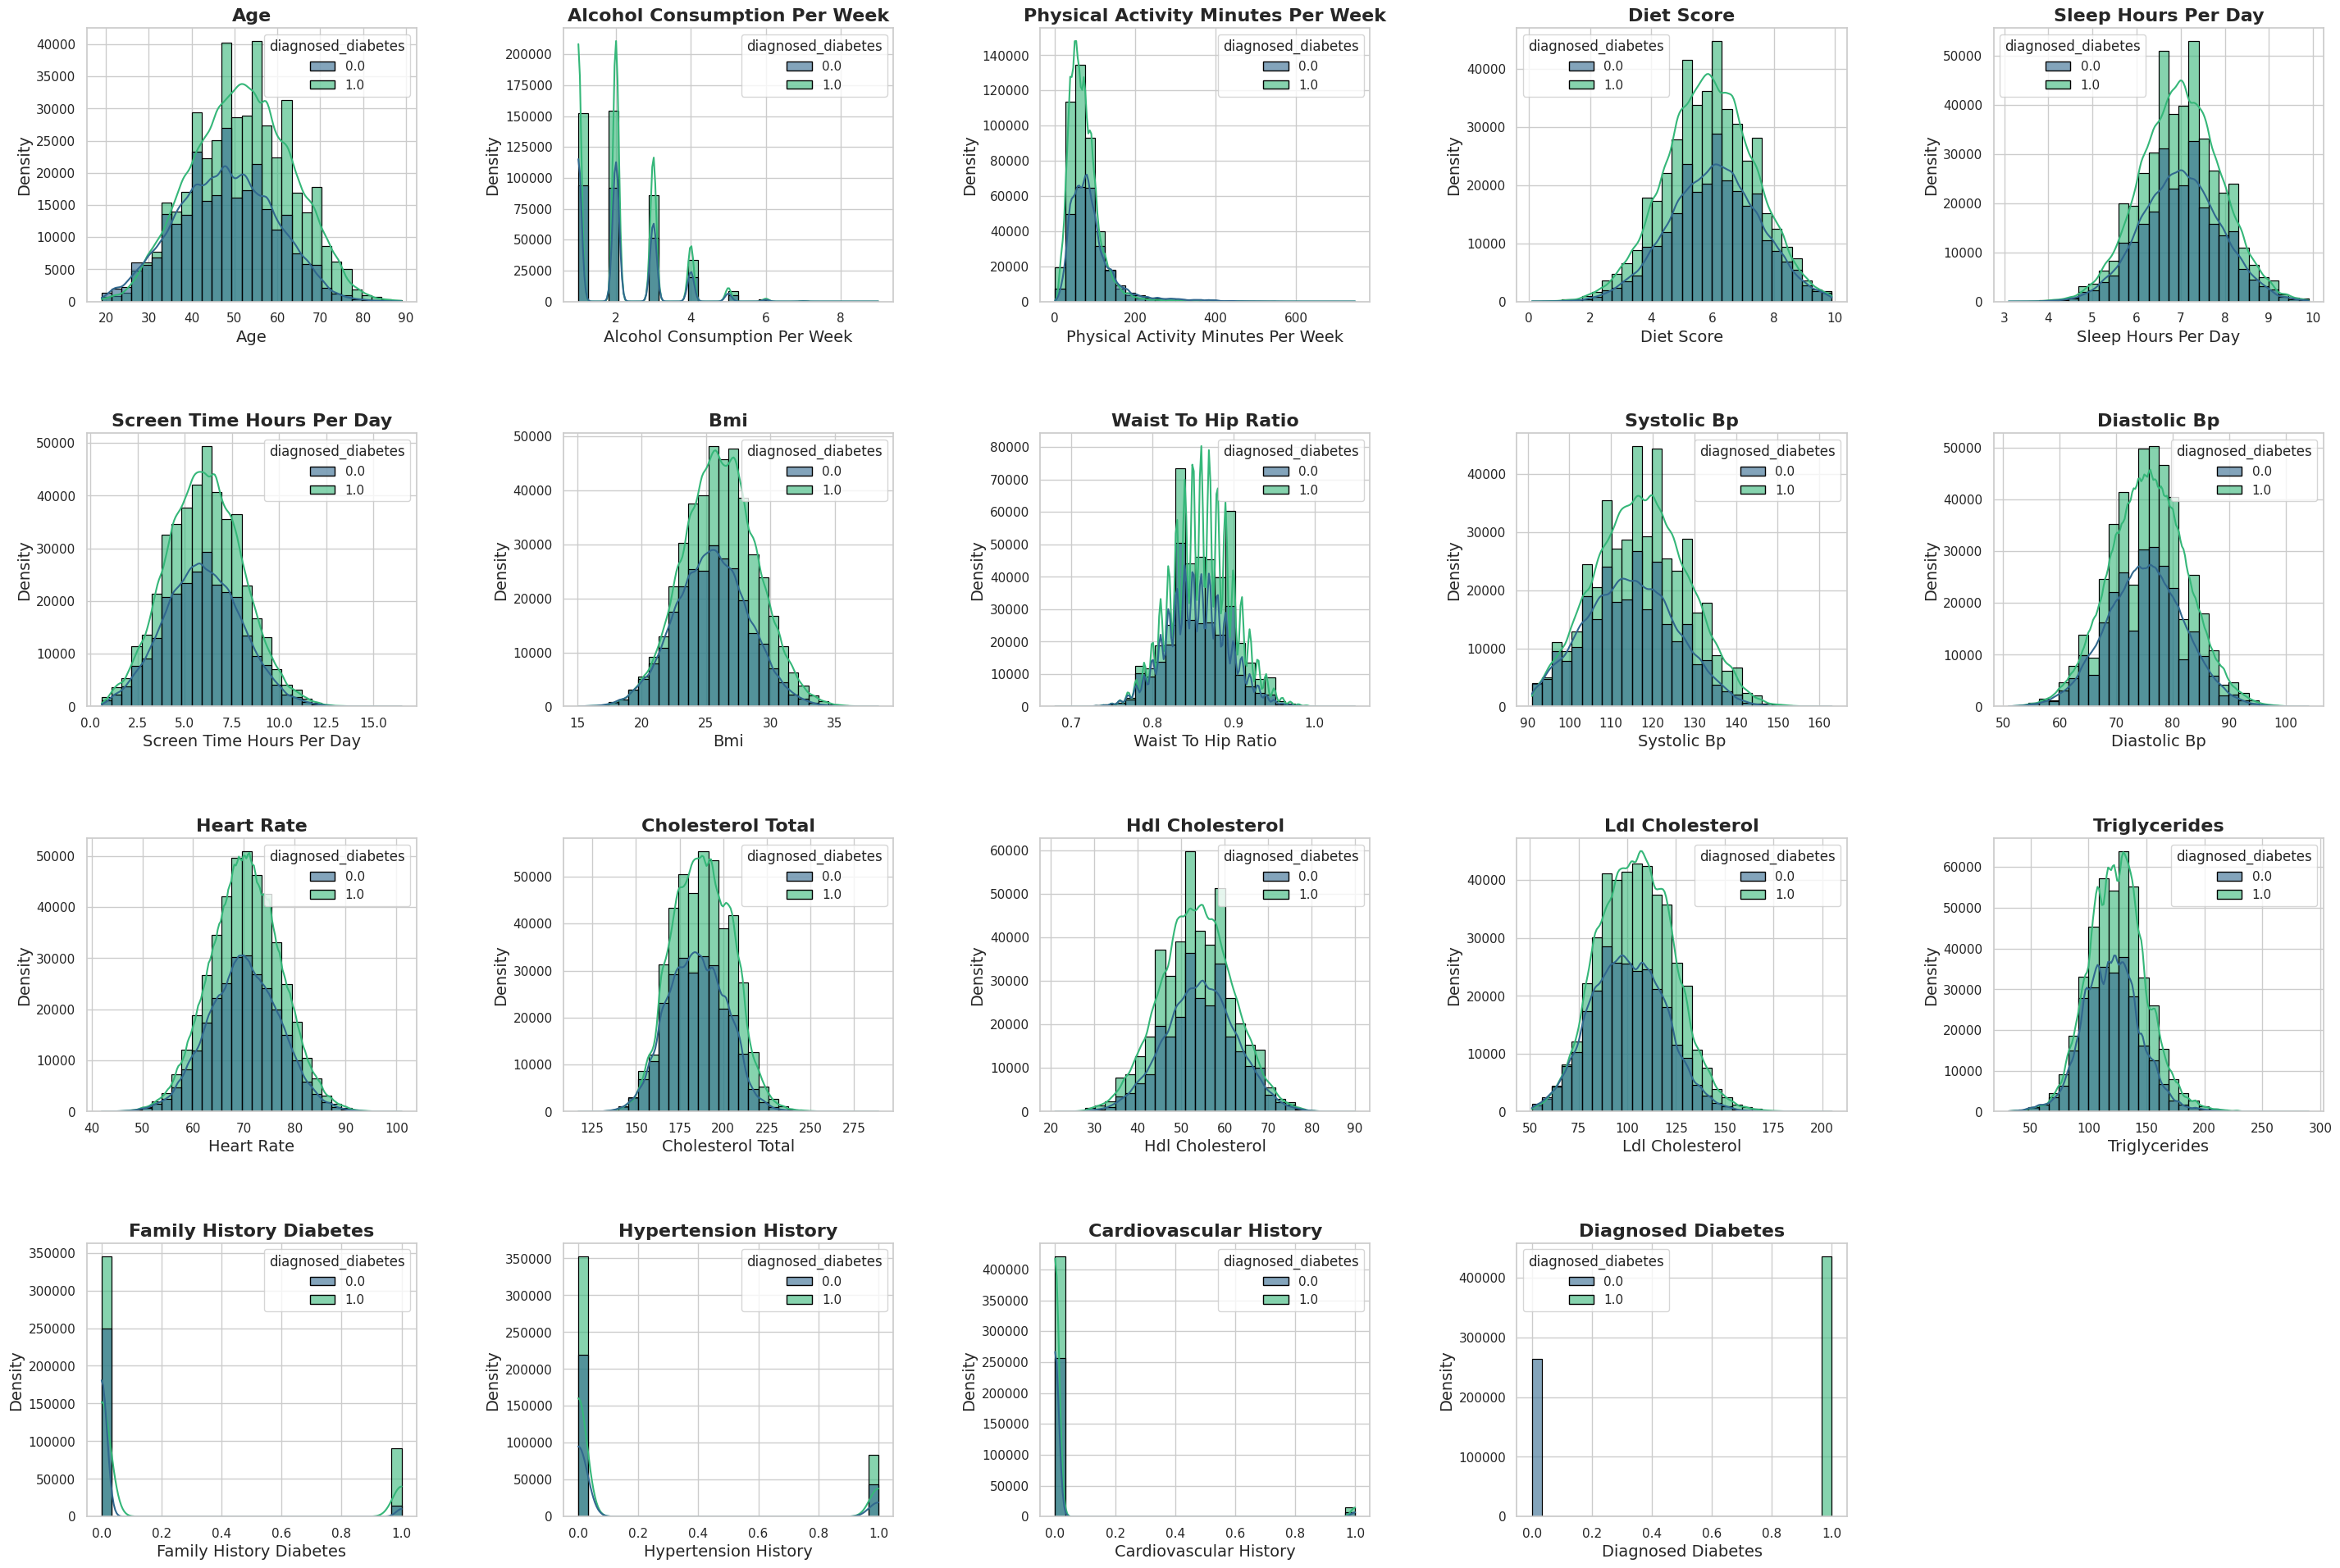

In [6]:
#check the distribution of continuous variables
plot_df = train[continuous_cols] 

N_COLS = 5
N_ROWS = 5
sns.set_theme(style='whitegrid', palette='viridis')
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(30, 25))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    sns.histplot(
        data=train,  
        x=col,
        hue=TARGET,
        ax=axes[i],
        kde=True,
        palette='viridis', 
        edgecolor='black',
        bins=30,
        alpha=0.6,
        common_norm=False 
    )
    title_name = col.replace("_", " ").title()
    axes[i].set_title(f'{title_name}', fontsize=16, fontweight='bold')
    axes[i].set_xlabel(title_name, fontsize=14)
    axes[i].set_ylabel('Density', fontsize=14)

# Hide any unused subplots
for j in range(len(continuous_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=5.0)
plt.show()

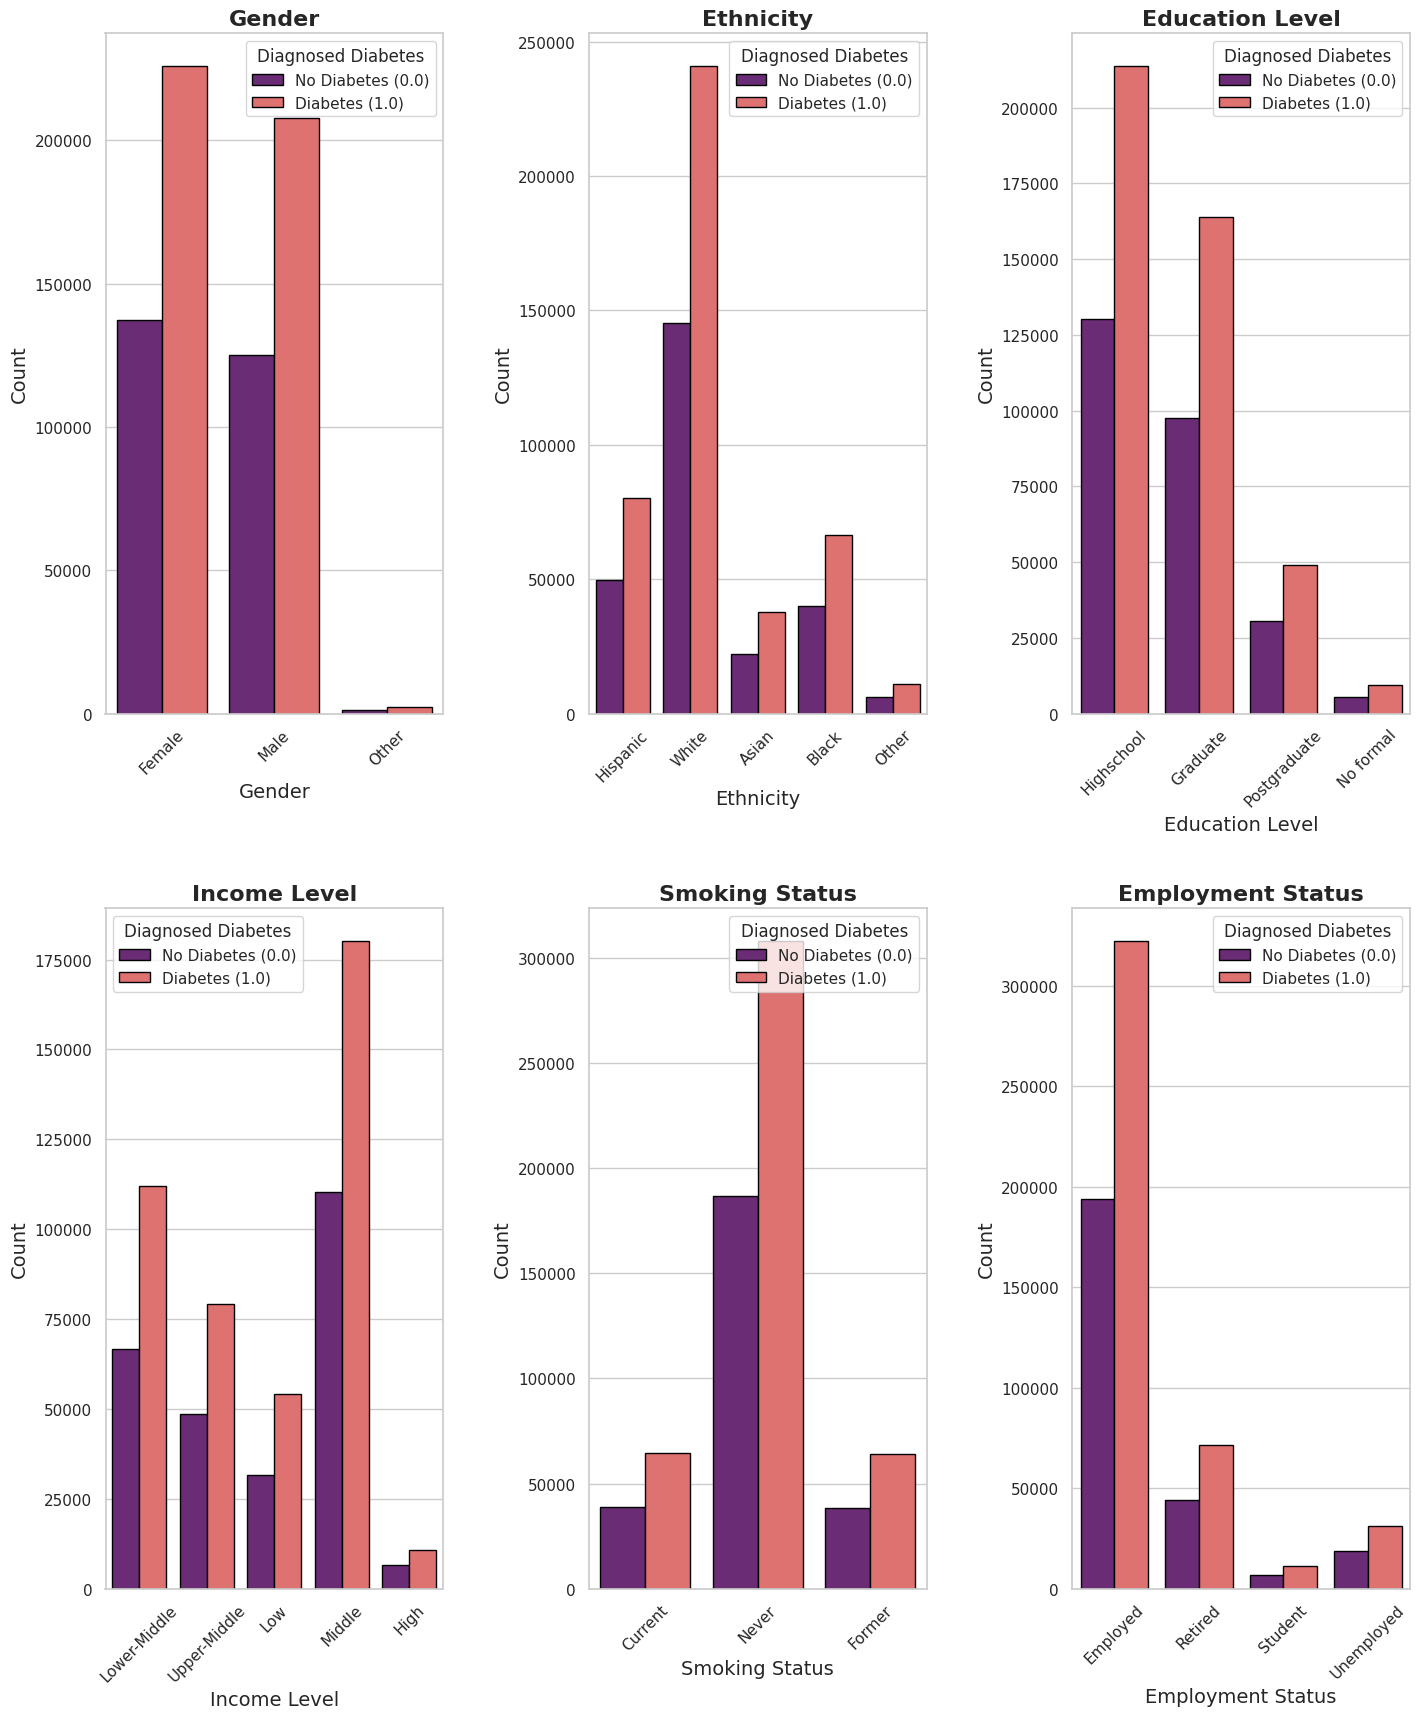

In [7]:
#check categorical distribution
sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 18))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(
        data=train,  
        x=col,
        hue=TARGET,
        ax=axes[i],
        palette='magma',
        edgecolor='black'
    )
    title_name = col.replace("_", " ").title()
    axes[i].set_title(f'{title_name}', fontsize=16, fontweight='bold')
    axes[i].set_xlabel(title_name, fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45) 
    axes[i].legend(title=TARGET.replace('_', ' ').title(), labels=['No Diabetes (0.0)', 'Diabetes (1.0)'])

plt.tight_layout(pad=3.0)
plt.show()


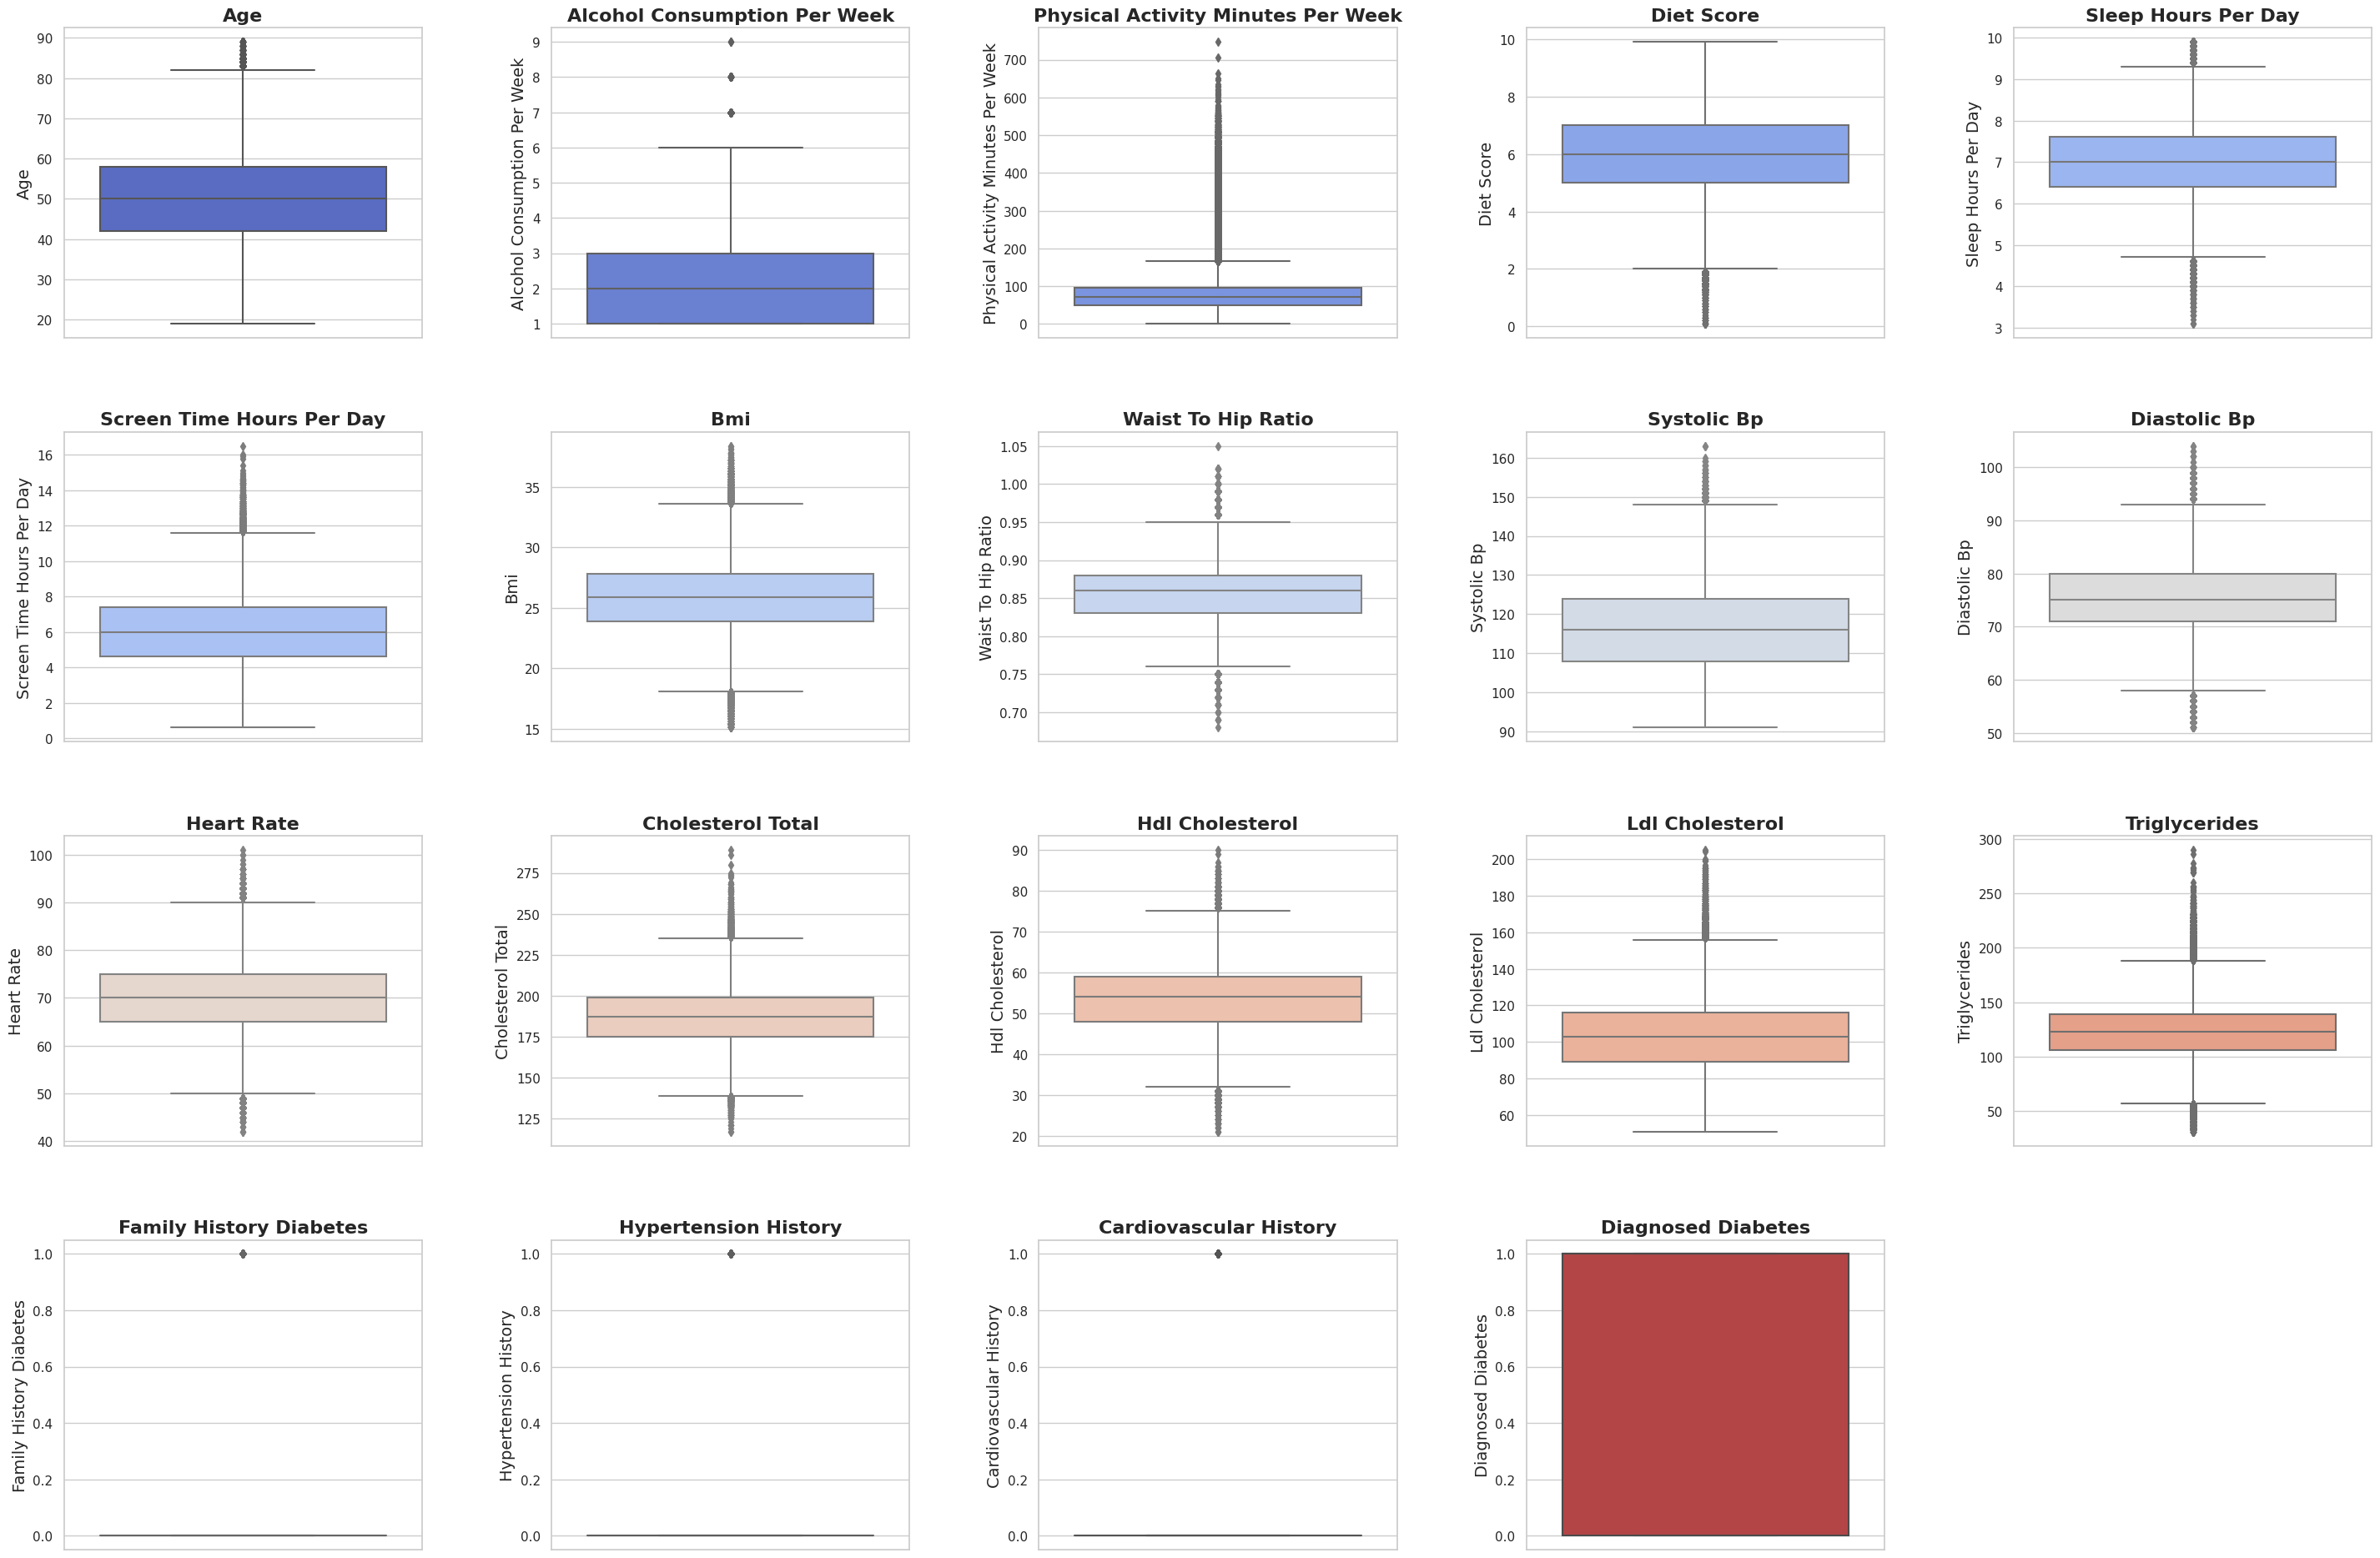

In [8]:
#check for outliers
plot_df = train[continuous_cols]

sns.set_theme(style="whitegrid", palette="coolwarm")
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(30, 25))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    sns.boxplot(
        y=plot_df[col],
        ax=axes[i],
        color=sns.color_palette("coolwarm", n_colors=len(continuous_cols))[i]
    )
    title_name = col.replace("_", " ").title()
    axes[i].set_title(
        f'{title_name}',
        fontsize=16,
        fontweight='bold'
    )
    axes[i].set_ylabel(title_name, fontsize=14)
    axes[i].tick_params(axis='x', labelbottom=False)

for j in range(len(continuous_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=5.0)
plt.show()

In [9]:
print("--- Categorical Feature Cardinality ---")
for col in cat_cols:
    cardinality = train[col].nunique()
    print(f"'{col}': {cardinality} unique values")

--- Categorical Feature Cardinality ---
'gender': 3 unique values
'ethnicity': 5 unique values
'education_level': 4 unique values
'income_level': 5 unique values
'smoking_status': 3 unique values
'employment_status': 4 unique values


In [10]:
#FeatureEngineer Class
class FeatureEngineer:
    def __init__(self):
        self.smoke_map = {'Never': 0, 'No': 0, 'Former': 1, 'Current': 2, 'Smoker': 2, 'Yes': 2}
        self.bmi_bins = [-1, 18.5, 25, 30, 100]
        self.bp_bins = [-1, 120, 130, 140, 300]
        
    def map_ordinals(self, df):
        df['smoking_status_risk'] = df['smoking_status'].map(self.smoke_map).fillna(0)
        return df

    def engineer_diabetes_features(self, df):
        # BMI Binning
        df['BMI_Cat'] = pd.cut(df['bmi'], bins=self.bmi_bins, labels=[0, 1, 2, 3]).astype(int)
        # Blood Pressure Binning
        df['BP_Risk_Level'] = pd.cut(df['systolic_bp'], bins=self.bp_bins, labels=[0, 1, 2, 3]).astype(int)
        
        # Interaction Features (Visceral_Fat, AIP, MAP)
        df['Visceral_Fat'] = df['bmi'] * df['waist_to_hip_ratio']
        df['AIP'] = np.log((df['triglycerides'] + 1) / (df['hdl_cholesterol'] + 1))
        df['MAP'] = (df['systolic_bp'] + 2 * df['diastolic_bp']) / 3
        
        return df
        
    def log_transform(self, df, cols):
        for col in cols:
            new_col = f'{col}_log'
            df[new_col] = np.log1p(df[col])
        return df

    def create_features(self, df):
        df = self.map_ordinals(df)
        df = self.engineer_diabetes_features(df)
        
        log_cols = ['triglycerides', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week']
        df = self.log_transform(df, log_cols)

        return df

In [11]:
fe_engine  = FeatureEngineer()
X = fe_engine.create_features(train.copy())
X = X.drop(columns=[TARGET])
y = train[TARGET].astype(int)

In [12]:
class XGBWrapper:
    def __init__(self, xgb_params: dict) -> None:
        self.model = xgb.XGBClassifier(**xgb_params)

    def fit(self, x, y, val_x, val_y):
        self.model.fit(x, y, eval_set=[(val_x, val_y)], verbose=300)

    def predict_proba(self, x):
        return self.model.predict_proba(x, iteration_range=(0, self.model.best_iteration + 1))


class LGBWrapper:
    def __init__(self, lgb_params: dict) -> None:
        self.model = LGBMClassifier(**lgb_params)

    def fit(self, x, y, val_x, val_y):
        self.model.fit(x, y, eval_set=[(val_x, val_y)])

    def predict_proba(self, x):
        return self.model.predict_proba(x)


class YDFWrapper:
    def __init__(self, ydf_params: dict) -> None:
        self.base_model = ydf.GradientBoostedTreesLearner(label=TARGET, **ydf_params)

    def fit(self, x, y, val_x, val_y):
        ds = x.copy()
        ds[TARGET] = y.astype(int)
        valid = val_x.copy()
        valid[TARGET] = val_y.astype(int)
        self.model = self.base_model.train(ds=ds, valid=valid)

    def predict_proba(self, x):
        p = self.model.predict(x).reshape((-1,1))
        y = np.hstack([1 - p, p])
        return y

class CatBoostWrapper:
    def __init__(self, cb_params: dict) -> None:
        self.model = CatBoostClassifier(**cb_params)

    def fit(self, x, y, val_x, val_y):
        self.model.fit(
            x, y,
            eval_set=[(val_x, val_y)],
            use_best_model=True,  
            verbose=False 
        )

    def predict_proba(self, x):
        return self.model.predict_proba(x)

In [13]:
class ModelTrainer:
    def __init__(self, config, continuous_cols, cat_cols):
        self.config = config
        self.continuous_cols = continuous_cols
        self.cat_cols = cat_cols
        self.skf = StratifiedKFold(n_splits=config.N_SPLITS, shuffle=True, random_state=config.SEED)
        
        self.preprocessor = self._get_preprocessor()

    def _get_preprocessor(self):
        return ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.continuous_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), self.cat_cols)
            ], 
            remainder='drop'
        )

    def run_cv_training(self, ModelWrapperClass, model_name, model_params, X, y, test_df):
        oof_preds = np.zeros(len(X))
        test_preds = np.zeros(len(test_df))
        
        X_processed = self.preprocessor.fit_transform(X)
        test_processed = self.preprocessor.transform(test_df)
        
       
        # Get feature names after OHE
        if hasattr(self.preprocessor.named_transformers_['cat'], 'get_feature_names_out'):
             cat_feature_names = list(self.preprocessor.named_transformers_['cat'].get_feature_names_out(self.cat_cols))
        else: 
             cat_feature_names = [f'cat_{i}' for i in range(X_processed.shape[1] - len(self.continuous_cols))]
             
        feature_names = self.continuous_cols + cat_feature_names
        
        X_df = pd.DataFrame(X_processed, index=X.index, columns=feature_names)
        test_df_processed = pd.DataFrame(test_processed, index=test_df.index, columns=feature_names)
        
        print(f"\n--- Starting {model_name} Training (N_SPLITS={self.config.N_SPLITS}) ---")

        for fold, (train_idx, val_idx) in enumerate(self.skf.split(X, y), 1):
            
            X_train, X_val = X_df.iloc[train_idx], X_df.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = ModelWrapperClass(model_params)
            
            model.fit(X_train, y_train, X_val, y_val)
            
            val_preds = model.predict_proba(X_val)[:, 1]
            oof_preds[val_idx] = val_preds
            
            test_preds += model.predict_proba(test_df_processed)[:, 1] / self.config.N_SPLITS

        avg_auc = roc_auc_score(y, oof_preds)
        print(f"\n{model_name} OOF AUC: {avg_auc:.6f} (All Folds)")
        return oof_preds, test_preds, avg_auc

In [14]:
os.makedirs('model_predictions', exist_ok=True)
def save_model_predictions(model_name, oof_preds, test_preds, train_ids=None, test_ids=None):

    oof_df = pd.DataFrame({
        'id': train_ids if train_ids is not None else range(len(oof_preds)), 
        f'{model_name}_oof': oof_preds
    })
    oof_filename = f'model_predictions/{model_name}_oof.csv'
    oof_df.to_csv(oof_filename, index=False)
    
    test_df = pd.DataFrame({
        'id': test_ids if test_ids is not None else range(len(test_preds)),
        f'{model_name}_test': test_preds
    })
    test_filename = f'model_predictions/{model_name}_test.csv'
    test_df.to_csv(test_filename, index=False)
    
    print(f"[{model_name}] Result saved:\n  - {oof_filename}\n  - {test_filename}")

In [15]:
if TARGET in continuous_cols:
    continuous_cols.remove(TARGET)
    
print(f"Final Continuous Features (excluding TARGET): {continuous_cols}")

Final Continuous Features (excluding TARGET): ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']


In [16]:
trainer = ModelTrainer(CFG, continuous_cols, cat_cols)

cat_oof, cat_test_preds, cat_auc = trainer.run_cv_training(
    ModelWrapperClass=CatBoostWrapper,
    model_name="CatBoost",
    model_params=CFG.cb_params_optuna, 
    X=X,
    y=y,
    test_df=test
)
save_model_predictions("catboost",cat_oof, cat_test_preds,train_ids=train.index,test_ids=test_ids)

ydf_oof, ydf_test_preds, ydf_auc = trainer.run_cv_training(
    ModelWrapperClass=YDFWrapper, 
    model_name="YDF (Random Forest)", 
    model_params=CFG.ydf_params_optuna, 
    X=X, 
    y=y, 
    test_df=test
)
save_model_predictions("YDF", ydf_oof, ydf_test_preds, train_ids=train.index, test_ids=test_ids)

xgb_oof, xgb_test_preds, xgb_auc = trainer.run_cv_training(
    ModelWrapperClass=XGBWrapper, 
    model_name="XGBoost (Optuna)", 
    model_params=CFG.xgb_params7_optuna,
    X=X, 
    y=y, 
    test_df=test
)
save_model_predictions("xgb", xgb_oof, xgb_test_preds, train_ids=train.index, test_ids=test_ids)


lgbm_oof, lgbm_test_preds, lgbm_auc = trainer.run_cv_training(
    ModelWrapperClass=LGBWrapper, 
    model_name="LightGBM (Optuna)", 
    model_params=CFG.lgb_params7_optuna, 
    X=X, 
    y=y, 
    test_df=test
)
save_model_predictions("lgbm", lgbm_oof, lgbm_test_preds, train_ids=train.index, test_ids=test_ids)


--- Starting CatBoost Training (N_SPLITS=5) ---


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU



CatBoost OOF AUC: 0.725317 (All Folds)
[catboost] Result saved:
  - model_predictions/catboost_oof.csv
  - model_predictions/catboost_test.csv

--- Starting YDF (Random Forest) Training (N_SPLITS=5) ---
Train model on 560000 training examples and 140000 validation examples
Model trained in 0:16:32.644435
Train model on 560000 training examples and 140000 validation examples
Model trained in 0:16:05.545595
Train model on 560000 training examples and 140000 validation examples
Model trained in 0:15:50.532217
Train model on 560000 training examples and 140000 validation examples
Model trained in 0:13:49.959951
Train model on 560000 training examples and 140000 validation examples
Model trained in 0:16:23.746147

YDF (Random Forest) OOF AUC: 0.728452 (All Folds)
[YDF] Result saved:
  - model_predictions/YDF_oof.csv
  - model_predictions/YDF_test.csv

--- Starting XGBoost (Optuna) Training (N_SPLITS=5) ---
[0]	validation_0-auc:0.57665
[300]	validation_0-auc:0.70434
[600]	validation_0-auc:0

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.



LightGBM (Optuna) OOF AUC: 0.724113 (All Folds)
[lgbm] Result saved:
  - model_predictions/lgbm_oof.csv
  - model_predictions/lgbm_test.csv


In [17]:
"""#output from trained models
INPUT_PATH = '/kaggle/input/predictions/model_predictions'

xgb_oof_df = pd.read_csv(f'{INPUT_PATH}/xgb_oof.csv')
lgbm_oof_df = pd.read_csv(f'{INPUT_PATH}/lgbm_oof.csv')
ydf_oof_df = pd.read_csv(f'{INPUT_PATH}/YDF_oof.csv')
cat_oof_df = pd.read_csv(f'{INPUT_PATH}/catboost_oof.csv')

xgb_test_df = pd.read_csv(f'{INPUT_PATH}/xgb_test.csv')
lgbm_test_df = pd.read_csv(f'{INPUT_PATH}/lgbm_test.csv')
ydf_test_df = pd.read_csv(f'{INPUT_PATH}/YDF_test.csv')
cat_test_df = pd.read_csv(f'{INPUT_PATH}/catboost_test.csv')"""

"#output from trained models\nINPUT_PATH = '/kaggle/input/predictions/model_predictions'\n\nxgb_oof_df = pd.read_csv(f'{INPUT_PATH}/xgb_oof.csv')\nlgbm_oof_df = pd.read_csv(f'{INPUT_PATH}/lgbm_oof.csv')\nydf_oof_df = pd.read_csv(f'{INPUT_PATH}/YDF_oof.csv')\ncat_oof_df = pd.read_csv(f'{INPUT_PATH}/catboost_oof.csv')\n\nxgb_test_df = pd.read_csv(f'{INPUT_PATH}/xgb_test.csv')\nlgbm_test_df = pd.read_csv(f'{INPUT_PATH}/lgbm_test.csv')\nydf_test_df = pd.read_csv(f'{INPUT_PATH}/YDF_test.csv')\ncat_test_df = pd.read_csv(f'{INPUT_PATH}/catboost_test.csv')"

In [18]:
#Level 2 train(Meta-Features)
X_meta = pd.DataFrame({
    'xgb_oof': xgb_oof,
    'lgbm_oof': lgbm_oof,
    'ydf_oof': ydf_oof,
    'cat_oof': cat_oof,
})

#Level 2 test(Meta-Test Features)
X_meta_test = pd.DataFrame({
    'xgb_oof': xgb_test_preds,   
    'lgbm_oof': lgbm_test_preds, 
    'ydf_oof': ydf_test_preds,   
    'cat_oof': cat_test_preds, 
})

y_meta = y

In [19]:
print("Models for ensemble:", X_meta.columns.tolist())

def hill_climbing_auc(oof_df, y_true, iterations=2000, step_size=0.001, verbose=True):
    model_cols = oof_df.columns
    n_models = len(model_cols)
    
    best_weights = np.ones(n_models) / n_models
    
    current_pred = np.dot(oof_df, best_weights)
    best_auc = roc_auc_score(y_true, current_pred)
    
    if verbose:
        print(f"Initial AUC (Equal Weights): {best_auc:.6f}")

    for i in range(iterations):
        model_idx = np.random.randint(n_models)
        
        direction = np.random.choice([-1, 1])
        
        new_weights = best_weights.copy()
        new_weights[model_idx] += direction * step_size
        
        if new_weights[model_idx] < 0:
            continue
            
        new_weights /= new_weights.sum()
        
        new_pred = np.dot(oof_df, new_weights)
        new_auc = roc_auc_score(y_true, new_pred)
        
        if new_auc > best_auc:
            best_weights = new_weights
            best_auc = new_auc
            if verbose and i % 200 == 0:
                print(f"Iter {i}: New Best AUC = {best_auc:.6f}")

    return best_weights, best_auc

print("\n Starting Hill Climbing optimization...")

best_weights, best_auc = hill_climbing_auc(X_meta, y, iterations=3000, step_size=0.002)

print("\n Optimization Complete")
print(f"Final OOF AUC: {best_auc:.6f}")
print("-" * 30)
print("Best Weights:")
weight_dict = dict(zip(X_meta.columns, best_weights))
for model, w in weight_dict.items():
    print(f"  - {model}: {w:.4f}")
print("-" * 30)

final_test_preds = np.dot(X_meta_test, best_weights)

Models for ensemble: ['xgb_oof', 'lgbm_oof', 'ydf_oof', 'cat_oof']

 Starting Hill Climbing optimization...
Initial AUC (Equal Weights): 0.728177
Iter 800: New Best AUC = 0.729305
Iter 1000: New Best AUC = 0.729448

 Optimization Complete
Final OOF AUC: 0.729463
------------------------------
Best Weights:
  - xgb_oof: 0.6254
  - lgbm_oof: 0.0001
  - ydf_oof: 0.3738
  - cat_oof: 0.0007
------------------------------


In [20]:
submission_hc = pd.DataFrame({
    'id': test_ids,
    'diagnosed_diabetes': final_test_preds 
})

file_name = 'submission_ensemble.csv'
submission_hc.to_csv(file_name, index=False)
print(f"\n Submitted: '{file_name}'")


 Submitted: 'submission_ensemble.csv'
